# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 109b: Advanced Topics in Data Science 
## Final Project Module B - Searching for Near Earth Asteroids


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

Michael Streyle, Jon Thompson, Jack Tsu, Andrew Welsh

<hr style="height:2pt">

You may have heard it in TV, movies, media or even science class: asteroids passing by and crashing into the earth. "Don't Look Up" released just a few months ago on Netflix; movies like Deep Impace or Armageddon...
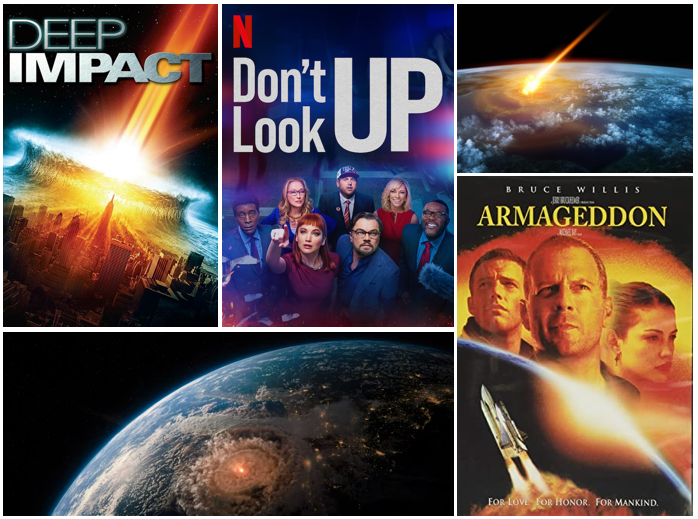

Or asteroids "the size of the great pyramid of Giza" passing nearby the Earth...


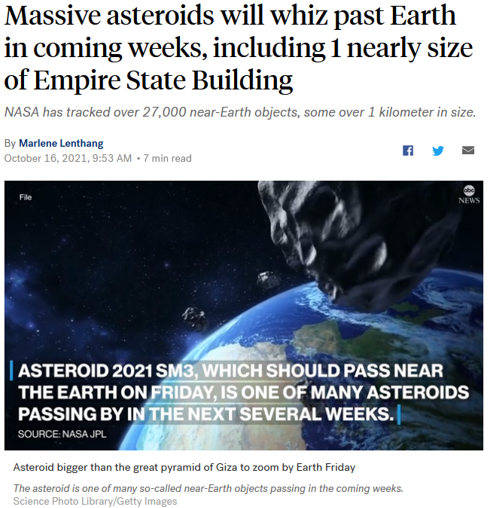

...the Chicxulub asteroid that crashed into the Yucatan peninsula 65 million years ago, causing the extinction of the dinosaurs...

...or the meteor in February 2013, captured on multiple dash and traffic cams, that exploded with the force of 30 Hiroshima bombs 30km over the city of Chelyabinsk, Russia, injuring 1,500 from the blown out windows and burns from the intense light...
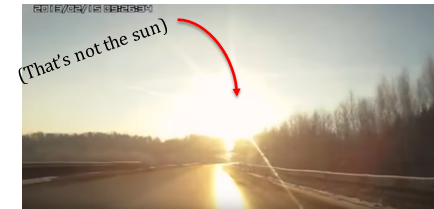

### Congressional Charter
The US Congress and NASA take the threat of asteroids seriously. In 2005, **the US Congress tasked NASA with discovering 90% of all asteroids 140m or larger in diameter by 2020.** The current estimate is about 10% have been found. While 90% of asteroids over 1km in size, big enough to cause extinction-level events, have been found, most of the smaller city-to-continental-level damage asteroids have yet to be discovered. It is not a question of if, but when, the next impact reaches us. Our goal is to detect these Near Earth Objects (NEO's) as early as possible in order to nudge it out of its collision path with Earth. Multiple facilities are working hard on this crucial planetary defense project, and in conjunction with the **Minor Planet Center (MPC) of the Smithsonian Astrophyiscal Observatory at Harvard University**, new asteroids are being identified and cataloged daily.

### Data Science is here to help
With the advent of big data processing pipelines, automated telescopes, and sensitive high resolution digital imaging, astronomers are able to survey the whole sky multiple times per week to track tiny changes over time. This has enabled an explosion of discoveries in supernovae, variable stars, exoplanets, comets and asteroids far beyond the casual happenstance discoveries of amateurs or professionals studying specific patches of sky for other reasons. Smaller telescopes within the budgets of mid-sized universities are able to aid in this search, allowing for wider participation.

This exciting new capability has come with an explosion of terabytes of data generated daily to comb through. This is where data science can aid astronomical science in automating this massive volume of information. This project aims to explore potential machine learning models that could reduce the amount of human intervention currently required for both the discovery of these asteroids, and prioritization of follow-up observations of potentially hazardous asteroids.

## Table of Contents

- [EDA](#eda)
- [Object Detection](#objectdetect)
- [Building an Ensemble Model to Classify Potentially Hazardous Asteroids](#classifier)
- [Orbital Parameter Model](#orbital)
- [Absolute Magnitude (H) Model](#h)
- [Minimum Orbit Intersection Distance (MOID) Model](#moid)
- [PHA Classifier Model Using Previous Models](#pha)
- [Results and Conclusions](#results)
- [References](#references)

## <a name="eda">EDA</a>

For this project, we're going to focus on two possible data sources. The [Catalina Sky Survey](https://sbn.psi.edu/pds/resource/css.html) and the [Asteroid Terrestrial-impact Last Alert System (ATLAS)](https://atlas.fallingstar.com/home.php). First, we'll explore some of the available data and associated metadata to get a sense of what is already being done and where data science and ML can assist.

### View Data from Catalina Survey
First we'll explore data from the Catalina Sky Survey (CSS). The images are stored in FITS (Flexible Image Transport System) format, the standard in the astronomical community.  Although the FITS standard is decades old, it is easily read and managed with the astropy library. A complete data dictionary for this data resides [here](https://sbn.psi.edu/pds/resource/css.html)

In [9]:
# Library Imports
import re
import os
import wget
import glob
import zipfile
import requests
import urllib.request
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import collections
import importlib

import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from astroquery.jplhorizons import Horizons
from boruta import BorutaPy

from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Dense
from tensorflow.keras.optimizers import SGD, Adam

from collections import defaultdict
from datetime import date
from os.path import exists
from scipy import spatial
from collections import Counter
from PIL import Image

# Astronomical Imports
import astropy
from astropy.io import fits
import astroalign as aa

# Turn off unnecessary Tensorflow output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline
from IPython.core.display import HTML

In [5]:
# get database inventory
inventory_url = f"https://sbnarchive.psi.edu/pds4/surveys/gbo.ast.catalina.survey/data_calibrated/collection_inventory_data_calibrated_v114.0.csv"
wget.download(inventory_url, "inventory.csv")
inventory = pd.read_csv("inventory.csv", header=None)[1].apply(lambda x: x.split(":")[5]+'.fz')

# download data utility
def get_filter_data(data_type="data_calibrated", telescope="G96", start_date=date(2021, 12, 2), end_date=date(2021, 12, 4), sky_id="N03015", sequences=1) -> list:
    """
    ex. url = https://sbnarchive.psi.edu/pds4/surveys/gbo.ast.catalina.survey/data_calibrated/G96/2021/21Dec01/
    ex. file_path = 703_20211202_2B_N02001_01_0001.arch.fz
    - checks if file exists locally
    - check if image in inventory
    - check if url works
    """
    fpath_list = []
    date_range = pd.date_range(start_date, end_date, freq='D')
    for day in date_range:
        for sequence in range(1,sequences+1):
            url = f"https://sbnarchive.psi.edu/pds4/surveys/gbo.ast.catalina.survey/{data_type}/{telescope}/{day.strftime('%Y')}/{day.strftime('%y%b%d')}/"
            fpath = f"{telescope}_{day.strftime('%Y%m%d')}_2B_{sky_id}_01_000{sequence}.arch.fz"
            if exists(fpath):
                fpath_list.append(fpath)
            elif fpath.lower() in inventory.values and requests.get(url+fpath):
                wget.download(url+fpath, fpath)
                fpath_list.append(fpath)
                print(f"\nDownloaded {day.strftime('%b %d')} Sequence {sequence}\n")
    print(f"Finished!")
    return fpath_list

In [8]:
# view some of the initial data from the catalina survey

# data filter settings
data_type = "data_calibrated"
telescope = "G96"
start_date = date(2021, 11, 27)
end_date = date(2022, 4, 13)
sky_id = "N03015"  # area of sky
sequences = 4   # 1~4

# get data
fpaths = get_filter_data(data_type, telescope, start_date, end_date, sky_id, sequences)


Downloaded Jan 25 Sequence 3


Downloaded Jan 25 Sequence 4

Finished!


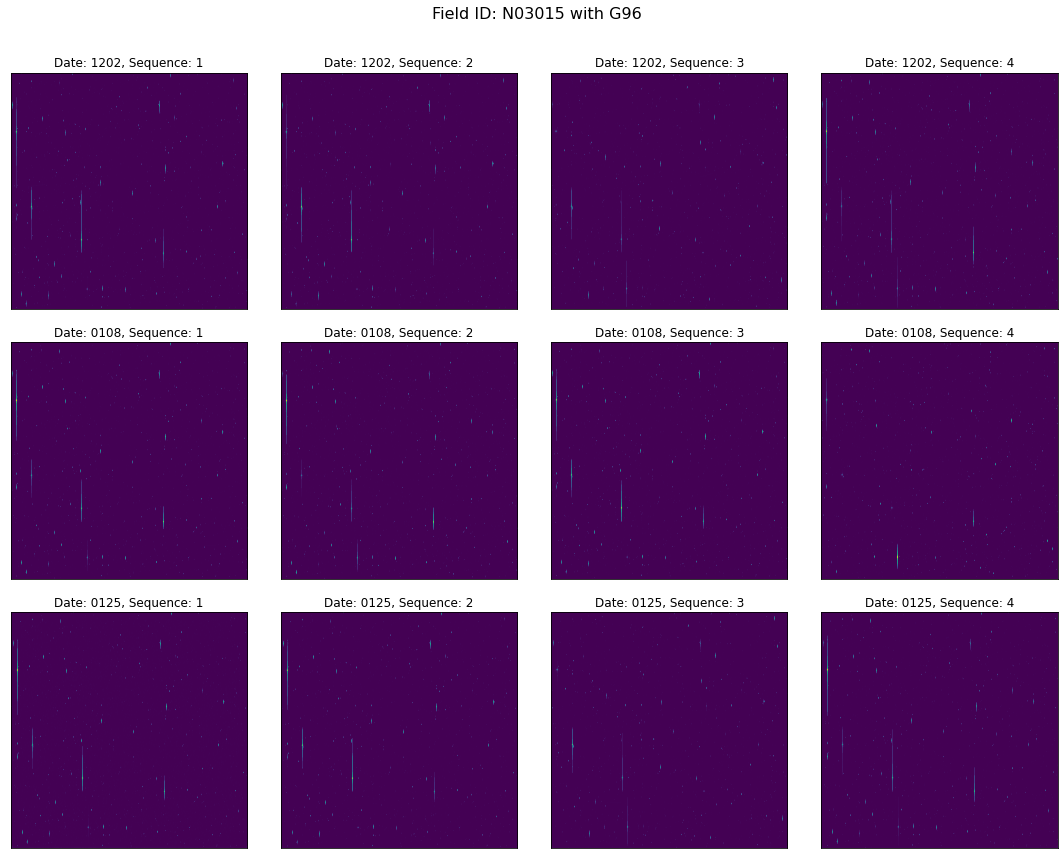

In [9]:
# Visualize
def plot_seq(fpaths, sequences):
    k = 0
    fig = plt.figure(figsize=(15,12))
    fig.suptitle(f'Field ID: {sky_id} with {telescope}',y=1.014,size=16)
    for idx in range(len(fpaths)):
        k += 1
        fpath = fpaths[idx]
        plt.subplot(len(fpaths)//sequences,sequences,k)
        plt.tight_layout()
        image_data = fits.getdata(fpath)
        plt.imshow(image_data)
        plt.title(f'Date: {fpath[8:12]}, Sequence: {idx % 4 + 1}')
        plt.xticks([])
        plt.yticks([])
    plt.show()

plot_seq(fpaths, sequences)

### View Data from Atlas Survey


The ATLAS telescopes are equipped with wide-field science-grade digital cameras.  The field of view is square, subtending 5.5 degrees on a side.  The detectors are 10K x 10K pixels.  The images are also stored in FITS format like the CSS data. This data was provided offline to students via a compressed file, and is not easily publicly accessible.

The dataset consists of compressed image files (FITS.fz), designation files (DPH, which are automatically identified moving objects across frames), and known asteroid files (KASTX, which are matched desginations and their orbital parameters for asteroids appearing in a given image in the sequence).

In [12]:
dir_name = '../atlas-neo-images/'
#dir_name = "/content/drive/MyDrive/E109b/atlas-neo-images/"
image_filenames = sorted(glob.glob(f'{dir_name}*.fits.fz'))
dph_filenames = sorted(glob.glob(f'{dir_name}*.dph'))
kastx_filenames = sorted(glob.glob(f'{dir_name}*.kastx'))

In [14]:
# utility
def convert_points(ra, dec) -> np.array:
    """
    unit vector of ra/dec
    """
    d2r = np.pi/180.
    x = np.cos(ra*d2r) * np.cos(dec*d2r)
    y = np.sin(ra*d2r) * np.cos(dec*d2r)
    z = np.sin(dec*d2r)
    points = np.array([x, y, z]).T
    return points

def match_dph_kastx(kastx_df, dph_df, KDtree_arc=2) -> list:
    """
    idx of known asteroids with matching light source
    """
    # get RA/DEC
    asteroids = kastx_df.loc[:, ['RA_DEG', 'DEC_DEG']]
    lights = dph_df.loc[:, ['RA', 'Dec']]
    # convert pts
    asteroids_pts = convert_points(asteroids['RA_DEG'], asteroids['DEC_DEG'])
    lights_pts = convert_points(lights['RA'], lights['Dec'])
    # cKDTree
    as_tree = spatial.cKDTree(asteroids_pts)
    l_tree = spatial.cKDTree(lights_pts)
    sr=(KDtree_arc/3600.)*np.pi/180.
    idx = as_tree.query_ball_tree(l_tree, sr)
    return [i for (i, k) in enumerate(idx) if len(k)==1]

def get_track(asteroid_id) -> list:
    """
    get pixel coords of asteroid: [(x1,x2,x3,x4), (y1,y2,y3,y4)]
    """
    track = []
    for s in range(4):
        try:
            coord = kastx[s].loc[asteroid_id, ['TPX', 'TPY']]
            track.append(coord)
        except:
            return []
    return list(zip(*track))

def plot_seq(tracks, asteroid_id, bb=50):
    k = 0
    fig = plt.figure(figsize=(15,6))
    fig.suptitle(f'Asteroid Designation: {asteroid_id}',y=0.9,size=16)
    for seq in range(4):
        k += 1
        hdus = fits.open(image_filenames[quad*4+seq])
        img = hdus['image'].data
        plt.subplot(1,4,k)
        plt.tight_layout()
        x, y = int(track[0][seq]), int(track[1][seq])
        plt.imshow(img[y-bb:y+bb, x-bb:x+bb])
        plt.imsave(f'asteroid-{seq}.jpg', img[y-bb:y+bb, x-bb:x+bb], dpi=500)
        plt.title(f'Sequence: {seq}')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [25]:
### get data of known asteroids for quad
quad = 1
###


names =  ['RA', 'Dec', 'm', 'idx', 'Type', 'xtsk', 'ytsk', 'minst', 'dminst', 'sky', 'major', 
          'minor', 'phi', 'probgal', 'apmag', 'dapmag', 'apsky', 'ap-fit']

kastx = {}
match = {}
desig = Counter()
for s in range(4):
    i = quad * 4 + s
    kastx_df = pd.read_csv(kastx_filenames[i], sep='\s+')
    dph_df = pd.read_csv(dph_filenames[i], sep='\s+', names=names, skiprows=1)
    match[s] = match_dph_kastx(kastx_df, dph_df)
    kastx[s] = kastx_df.iloc[match[s]].set_index('DESIG')
    desig += Counter(kastx[s].index)

# filter asteroids in all 4 sequences
desig = {key: value for key, value in desig.items() if value == 4}
for s in range(4):
    kastx[s] = kastx[s].loc[desig.keys()]

<IPython.core.display.Javascript object>


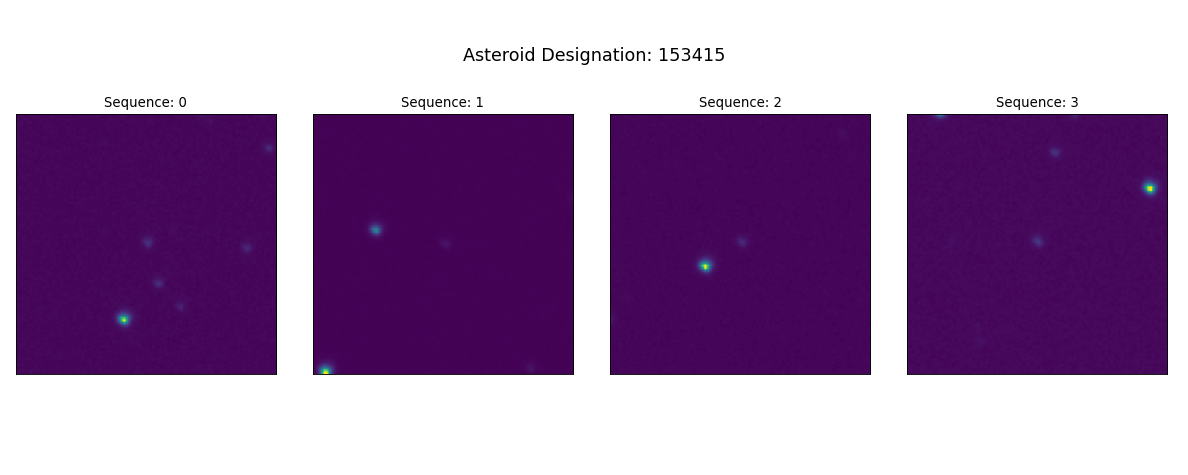

In [26]:
id = -1
asteroid_desig = '173'
if id:
    asteroid_desig = kastx[0].index[id]

track = get_track(asteroid_desig)
plot_seq(track, asteroid_desig)


#### View Asteroid as Animation

In this animation, the asteroid is hard to see but is in the center of the image. As the animation progresses through the 4 images in the sequence, we can see the stationary stars and galaxies move as the asteroid is stationary in the center of the image. 

<IPython.core.display.Javascript object>


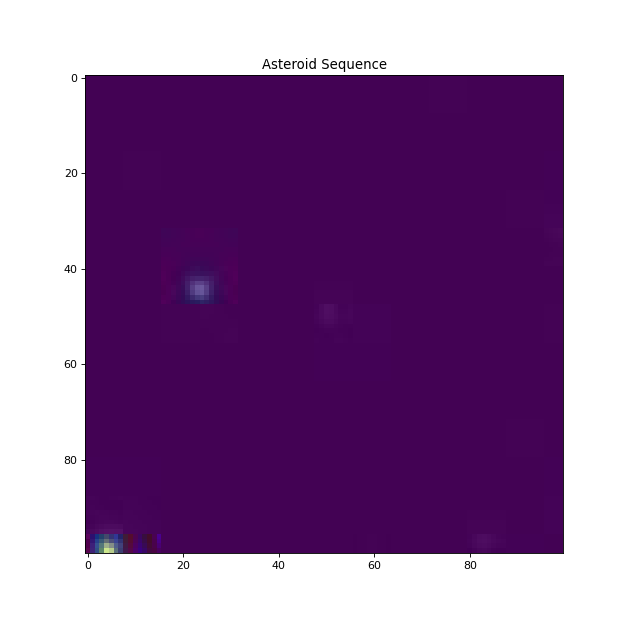

In [27]:
%matplotlib notebook

images = ['asteroid-0.jpg', 'asteroid-1.jpg', 'asteroid-2.jpg', 'asteroid-3.jpg']
fig2, ax2 = plt.subplots(figsize=(8,8))

ims = []
for i in range(4):
    ima = Image.open(images[i])
    im = ax2.imshow(ima, animated=True)
    ax2.set_title(f'Asteroid Sequence')
    ims.append([im])

ani = animation.ArtistAnimation(fig2, ims, interval=1000, blit=True,
                                repeat_delay=0)
plt.show()

## <a name="objectdetect">Object Detection</a>

Since 1904, astronomers have used the "blink comparator" method to identify changes over time to a section of sky. Early technology used glass plate photographs to compare two images. With the advent of digital photography, this task is done on computers nowadays. With digital images, there are frequently image artifacts that are in one image but not the other: digital noise, cosmic ray strikes, specks of dust on the sensor, and residual patterns of the image sensor itself. Man-made satellites, airplanes and tiny meteorites (shooting stars) also can appear on individual images. One of the manual tasks today is for an operator to verify whether a difference in "blinked" images is indeed an asteroid or not. 

The first task that may be practical for a data science approach would be to use ML to classify whether a potential "moving objects" is indeed an object or one of the aforementioned artifacts. In order to accomplish the blink comparison, each set of 4 images must be aligned such that the relatively stationary stars in the image appear in the same pixel coordinates. This way, subtracting the pixel brightness values will result in blank space where a star or empty space appear in the image. A moving object, however, will stand out as it will have change pixel positions between images.

#### Image alignment
To configure the digital blink comparator, the stars in each image must be aligned. A close inspection of the data from ATLAS shows the telescope changes where it is pointing slightly between exposures, resulting in shifts of a few pixels from frame to frame for a given fixed object.  A python library, astroalign, already exists to try to accomplish this mathematically complicated task.

First, let's look at a sequence of 4 images from ATLAS.

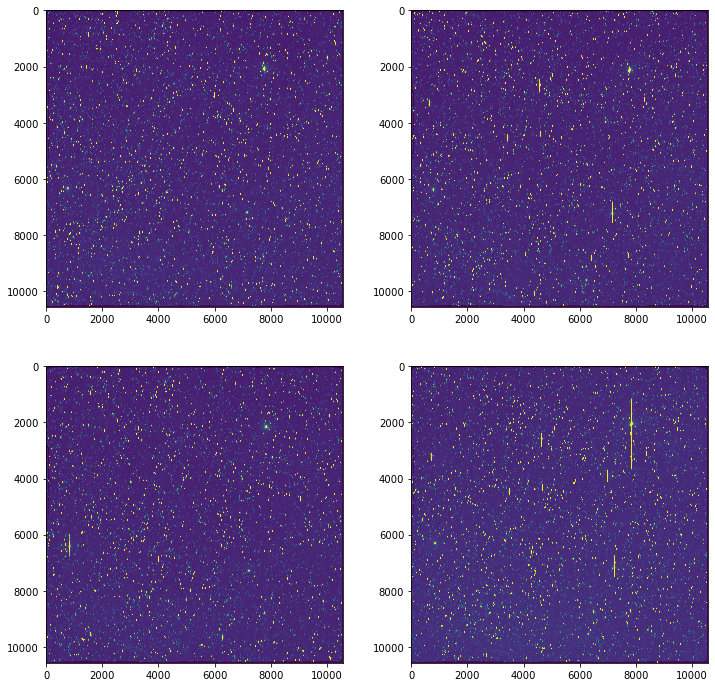

In [29]:
img_data = []   
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    img = fits.open(image_filenames[image_number])['image'].data
    img_data.append(img)
    ax.imshow(img, vmin=150, vmax=500)

By viewing a cropped section of each image, we can clearly see the 4 images in the sequence are not aligned. 

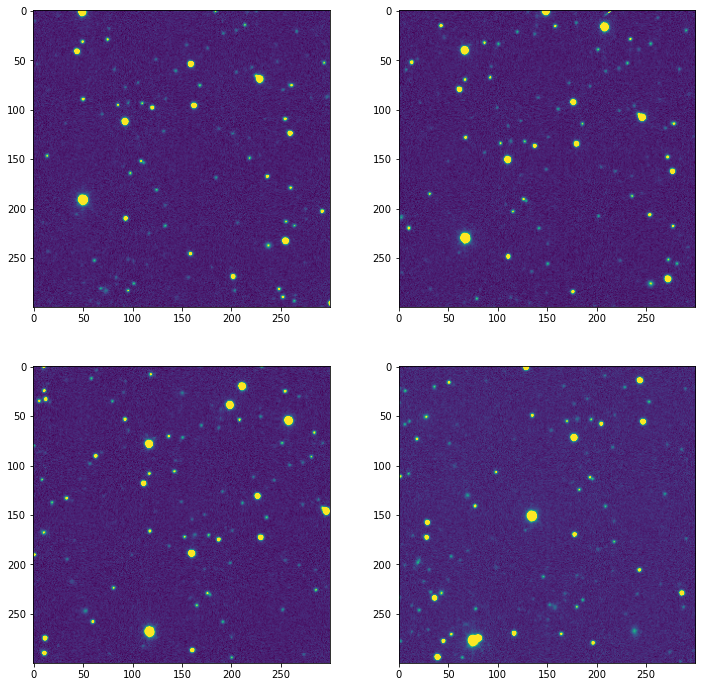

In [30]:
center_x = 3345
center_y = 5290
pad = 150
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    img = fits.open(image_filenames[image_number])['image'].data
    img_data.append(img)
    ax.imshow(img[center_x-pad:center_x+pad, center_y-pad:center_y+pad], vmin=150, vmax=500)

Next, we'll attempt alignment using the astroalign library. 

In [31]:
# define function to take 4 images and align them to second image
# this takes several minutes to run

def align_quad(img1, img2, img3, img4):
    registered, footprint = aa.register(img1, img2)
    registered3, footprint = aa.register(img3, img2)
    registered4, footprint = aa.register(img4, img2)
    return [registered, img2, registered3, registered4]

aligned_imgs = align_quad(img_data[0], img_data[1], img_data[2], img_data[3])

View aligned images:

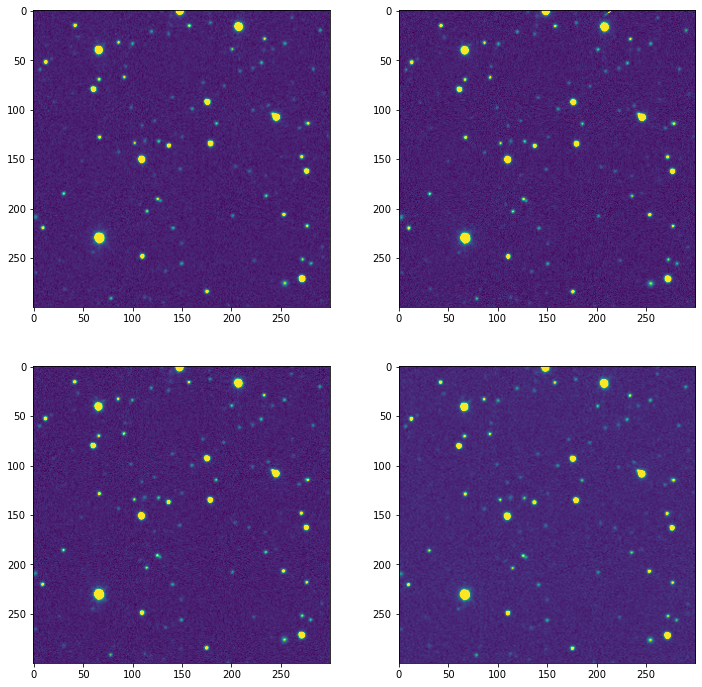

In [34]:
center_x = 3345
center_y = 5290
pad = 150
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    ax.imshow(aligned_imgs[image_number][center_x-pad:center_x+pad, center_y-pad:center_y+pad], vmin=150, vmax=500)

After the image alignment, the 4 images in a sequence are much more aligned pixel by pixel. This will allow us to more easily detect moving objects in the sequence of images. 

#### Blink comparator

In an effort to reduce the effect of camera sensor noise or slight variations in sky brightness altering the pixel brightness for a given star, we'll take the average of the 4-panel images as the "master background image". This averaged image will then be subtracted from each individual panel, and hopefully any moving objects will appear as isolated bright spots, but with the bright stars (largely) subtracted out. 

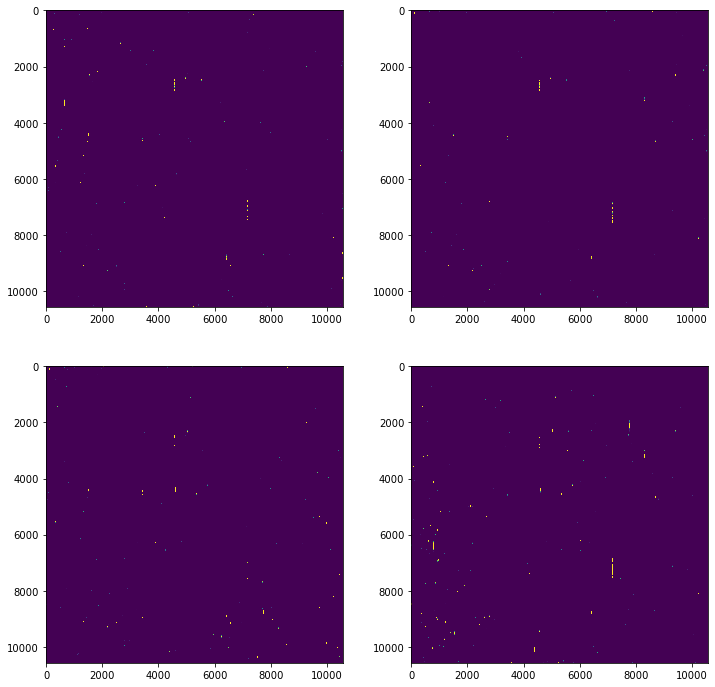

In [36]:
# Take average of all images in sequence and subtract from each image
avg = np.mean(aligned_imgs, axis=0)

fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    new_image = aligned_imgs[image_number]-avg
    ax.imshow(new_image, vmin=150, vmax=500)

After subtracting the average from each image, we can see some of the stars remain in the image. This is due to the failure of the images to align exactly.

### Trying a Detection Model with a CNN

Next, we attempted to make a detection model using a convolutional neural network (CNN). We found a paper in a research journal, Remote Sensing, which recommended a 10-layer CNN to track small moving objects. We attempted to build a CNN using a similar architecture ourselves. The plan was to input a small patch of sky into the model (100x100x4), run it through the CNN, and output a single sigmoid-activated value to determine the presence or absence of an asteroid in the image.

Building the CNN was mostly a "lessons learned" experience for us. A CNN is not a good approach for images like these, because we are looking for individual pixels rather than large-scale features in the image, and every patch of sky looks essentially the same. This means that there is nothing for a CNN to convolve.

*Works Cited: "A Method for Detection of Small Moving Objects in UAV Videos," Stojnic et al. 2021. Remote Sensing. https://www.mdpi.com/2072-4292/13/4/653/pdf*

In [7]:
def build_cnn():
    model = Sequential(name='CNN')
    
    # The input to the CNN should be a quad set of 100x100 images. (We can slice each 10000x10000 image into many pieces.)
    model.add(Input(shape=(100,100,4)))
    
    # Three convolutional layers with increasing filters number of filters, with 3x3 kernels and maxpooling.
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding="same"))
    model.add(MaxPool2D(pool_size=2, strides=2, padding="valid"))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding="same"))
    model.add(MaxPool2D(pool_size=2, strides=2, padding="valid"))
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding="same"))
    model.add(MaxPool2D(pool_size=2, strides=2, padding="valid"))
    
    # Three convolutional layers with decreasing number of filters, no pooling.
    model.add(Conv2D(filters=512, kernel_size=1, strides=1, padding="same"))
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding="same"))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding="same"))
    
    # The output will be the probability that this part of the image contains an asteroid.
    model.add(Dense(units=1, activation="sigmoid"))
    
    return model

In [6]:
detection_cnn_model = build_cnn()

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
detection_cnn_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

detection_cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      2368      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 256)      0       

#### Object Detection Model: Conclusion

Our project team felt it was outside of the scope of this project to tackle the alignment problem, and the CNN approach ended up not being effective, as there isn't much to convolve over when the things being detected are such a tiny portion of the overall image. We decided instead to focus on an entirely different modeling approach to help find NEOs.

### ATLAS dhp files

The ATLAS dhp files are identified objects corresponding to each image, and represent the output of their automated imaging pipeline. Since we felt the object detection problem was sufficiently automated, we strove to understand the outputs of this step as potential inputs to the next step: classifying whether the object is a Potentially Hazardous Asteroid or not.

In [ ]:
dph_filenames=sorted(glob.glob('atlas-neo-images/*.dph'))
dph_filenames

In [ ]:
names =  ['RA', 'Dec', 'm', 'idx', 'Type', 'xtsk', 'ytsk', 'minst', 'dminst', 'sky', 'major', 
          'minor', 'phi', 'probgal', 'apmag', 'dapmag', 'apsky', 'ap-fit']

df = pd.read_csv(dph_filenames[8], sep='\s+', names=names, skiprows=1)
df['quad'] = 1
df2 = pd.read_csv(dph_filenames[9], sep='\s+', names=names, skiprows=1)
df2['quad'] = 2
df3 = pd.read_csv(dph_filenames[10], sep='\s+', names=names, skiprows=1)
df3['quad'] = 3
df4 = pd.read_csv(dph_filenames[11], sep='\s+', names=names, skiprows=1)
df4['quad'] = 4

In [ ]:
# add the dataframes
# this now represents all the objects that were detected in this quad. 
# with a "quad" column to identify which image the object is in

df_all = pd.concat([df, df2, df3, df4], ignore_index=True)
df_all.head()

The DPH file contents from the ATLAS survey are key inputs. They provide the results of the object classification as performed by the automated pipeline as the telescope data is processed. While we would proceed with this as our training dataset, the limited availability of ATLAS data drove us to seek out a more complete dataset. We found the JPL Horizons meets this requirement and we explore its use in the next section.

## <a name="classifier">Building an Ensemble Model to Classify Potentially Hazardous Asteroids</a>

We decided to focus our efforts on the problem of classifying Potentially Hazardous Asteroids. To do this, we created an ensemble model, scaffolded together to get all of the data that we would need to classify PHAs.

It consisted of four parts:
- An orbital model, to estimate via prediction the orbital parameters of the detected object, which is an input for the other models.
- An absolute magnitude (H) model, to estimate the absolute magnitude, which is a standardized measure of brightness that functions as a proxy for the object's size.
- A Minimum Orbit Intercept Distance (MOID) regressor model, using orbital parameters, to determine how close it will get to earth at its nearest approach.
- Finally, a PHA classifier model, which incorporates our model outputs for H and MOID and determines the likelihood of an object being a Potentially Hazardous Asteroid (PHA).

**Using this appraoch, based on a 4-image sequence of a detected object, our classifier model can be used to rapidly assess whether it is likely a PHA or not.**

### JPL Horizons Data

We found a comprehensive training dataset from the JPL Horizons project, which has a complete catalog of all known asteroids orbiting the sun. With this large corpus of data, we can simulate the information that can be captured at the telescope and build our PHA classifier.

In [304]:
def convert_name(name) -> str:
    """
    change jpl file asteroids names to legal horizon searchable name
    ie. "2022HM4" -> "2022 HM4"
    Thanks @ Jon
    """
    split = re.split('([A-Z])', name)
    post = "".join(split[1:])
    return " ".join([split[0], post]).strip()

def convert2sbdb(name) -> str:
    """
    convert name to sbdb file index
    ie. "368529 (2003 WX55)" -> "2003WX55"
    """
    return "".join(re.split('[\(\)]', name)[-2].split())
  
def random_epochs(steps=1.0) -> list:
    """
    generate list of 4 julian dates in steps from 2020.1.1 ~ 2022.5.4
    """
    jd_20200101 = 2458849.5000000
    jd_22220504 = 2459703.4999884
    start = np.random.uniform(jd_20200101, jd_22220504)
    epochs = np.arange(start, start+steps*4, steps)
    return epochs

def get_random_horizon(name_index):
    """
    using astroquery horizon to get ephemerides + orbital elements with random object
    """
    epochs = random_epochs()
    obj = convert_name(np.random.choice(name_index))
    eph = Horizons(id=obj, location='T05', epochs=epochs, id_type='smallbody').ephemerides()
    orb = Horizons(id=obj, location='10', epochs=epochs, id_type='smallbody').elements()
    eph = eph.to_pandas().to_numpy()
    orb = orb['e', 'incl', 'a', 'H'].to_pandas().iloc[:1].to_numpy().flatten()
    return eph, orb

# plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [136]:
# load small body database
sbdb_df = pd.read_csv("sbdb_query_results.csv", index_col='pdes', low_memory=False)
sbdb_df.index = sbdb_df.index.map(lambda x: str(x).replace(" ", ""))
sbdb_df['pha'] = sbdb_df['pha'].apply(lambda x: 1 if x == "Y" else 0)
sbdb_df.dropna(inplace=True)
print(sbdb_df.shape)
sbdb_df.head()

(1099143, 9)


e      a      i      om       w      ma     H  moid  pha
pdes                                                               
1     0.0785  2.766  10.59   80.27   73.64  291.38  3.31  1.58    0
2     0.2300  2.771  34.93  172.92  310.70  272.48  4.11  1.23    0
3     0.2569  2.669  12.99  169.85  247.94  261.30  5.28  1.03    0
4     0.0882  2.361   7.14  103.80  151.09    7.03  3.40  1.14    0
5     0.1901  2.575   5.37  141.57  358.74  160.98  6.98  1.10    0

In [137]:
# data split
train_index, test_index = train_test_split(sbdb_df.index, test_size=0.1, random_state=109)
print(train_index.shape)
print(test_index.shape)

(989228,)
(109915,)


In [138]:
# sample horizon data
epochs = random_epochs()
obj = convert_name(np.random.choice(train_index))
eph = Horizons(id=obj, location='T05', epochs=epochs, id_type='smallbody').ephemerides()

print(eph[0])

 targetname        datetime_str          datetime_jd      H     G   solar_presence flags    RA      DEC     RA_app DEC_app   RA_rate    DEC_rate      AZ        EL      AZ_rate      EL_rate      sat_X      sat_Y    sat_PANG siderealtime airmass magextinct   V      surfbright  illumination illum_defect sat_sep  sat_vis ang_width PDObsLon PDObsLat PDSunLon PDSunLat SubSol_ang SubSol_dist NPole_ang NPole_dist  EclLon EclLat       r          r_rate       delta        delta_rate  lighttime   vel_sun    vel_obs    elong   elongFlag alpha  lunar_elong lunar_illum sat_alpha sunTargetPA velocityPA OrbPlaneAng constellation  TDB-UT  ObsEclLon  ObsEclLat NPole_RA NPole_DEC   GlxLon     GlxLat    solartime   earth_lighttime RA_3sigma DEC_3sigma SMAA_3sigma SMIA_3sigma Theta_3sigma  Area_3sigma  RSS_3sigma   r_3sigma   r_rate_3sigma SBand_3sigma XBand_3sigma DoppDelay_3sigma true_anom  hour_angle alpha_true PABLon PABLat
    ---                ---                    d          mag   ---       ---   

In [146]:
# Load data
X_train = np.load("X_train_full1.npy", allow_pickle=True)
y_train = np.load("y_train_full1.npy", allow_pickle=True)

X_test = np.load("X_test_full.npy", allow_pickle=True)
y_test = np.load("y_test_full.npy", allow_pickle=True)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(26000, 4, 83)
(26000, 4)
(2000, 4, 83)
(2000, 4)


In [149]:
# Filter columns
col_names = eph.colnames
ext_col_names = [f"{name}_{s}" for s in range(4) for name in col_names]
excl_names = ["targetname", "datetime_str", "H", "G", "solar_presence", "flags", "surfbright", "magextinct", "illum_defect", "sat_vis", "ang_width", "PDObsLon", "PDObsLat", "PDSunLon", "PDSunLat", "NPole_ang", "NPole_dist", "elongFlag", "constellation", "NPole_RA", "NPole_DEC"]
ext_excl_names = [f"{name}_{s}" for s in range(4) for name in excl_names]

# set df
X_train_flat = X_train.reshape((X_train.shape[0], 83*4))
X_test_flat = X_test.reshape((X_test.shape[0], 83*4))
X_train_df = pd.DataFrame(X_train_flat, columns=ext_col_names)
X_test_df = pd.DataFrame(X_test_flat, columns=ext_col_names)
y_train_df = pd.DataFrame(y_train, columns=["e", "a", "incl", "H"])
y_test_df = pd.DataFrame(y_test, columns=["e", "a", "incl", "H"])

# drop exclusion columns
print(len(ext_excl_names))
X_train_df_clean = X_train_df.drop(ext_excl_names, axis=1).astype("float")
X_test_df_clean = X_test_df.drop(ext_excl_names, axis=1).astype("float")

# scale
orbit_scaler = StandardScaler()
orbit_scaler.fit(X_train_df_clean)
X_train_scaled = orbit_scaler.transform(X_train_df_clean)
X_test_scaled = orbit_scaler.transform(X_test_df_clean)
X_train_scaled.shape

84


(26000, 248)

### Feature Selection with Boruta

In [163]:
# feature selection with Boruta
forest = RandomForestRegressor(max_depth=5, random_state=42)
boruta = BorutaPy(estimator=forest, 
                  n_estimators='auto',
                  max_iter=20)

select_cols = []
for i in range(4):
    boruta.fit(X_train_scaled[:1000,:], y_train_df.iloc[:1000, i].to_numpy())
    select_cols_ = boruta.support_.nonzero()[0]
    select_cols.append(select_cols_)
select_cols = sorted(set(np.concatenate(select_cols)))

# index columns to X_train_df_clean.columns
print(f"Important columns:", X_train_df_clean.columns[select_cols])

Important columns: Index(['V_0', 'EclLat_0', 'r_0', 'r_rate_0', 'delta_0', 'lighttime_0',
       'vel_sun_0', 'OrbPlaneAng_0', 'SMIA_3sigma_0', 'true_anom_0',
       'PABLat_0', 'V_1', 'EclLat_1', 'r_1', 'r_rate_1', 'delta_1',
       'lighttime_1', 'vel_sun_1', 'OrbPlaneAng_1', 'SMIA_3sigma_1',
       'true_anom_1', 'PABLat_1', 'V_2', 'EclLat_2', 'r_2', 'r_rate_2',
       'delta_2', 'lighttime_2', 'vel_sun_2', 'OrbPlaneAng_2', 'SMIA_3sigma_2',
       'true_anom_2', 'PABLat_2', 'V_3', 'EclLat_3', 'r_3', 'r_rate_3',
       'delta_3', 'lighttime_3', 'vel_sun_3', 'OrbPlaneAng_3', 'ObsEclLat_3',
       'SMIA_3sigma_3', 'true_anom_3', 'PABLat_3'],
      dtype='object')


In [172]:
# filter X columns
X_train_select = X_train_scaled[:, select_cols]
X_test_select = X_test_scaled[:, select_cols]
print(X_train_select.shape)
print(X_test_select.shape)

(26000, 45)
(2000, 45)


## <a name="orbital">Orbital Parameter Model</a>

This is the first stage in our scaffolded ensemble model. Our aim is to predict the eccentricty, inclination and semimajor axis distance from the sun of the detected object's orbit, using the input data derived from image sequences.

In [167]:
# y labels
var = ["e", "a", "incl"]

In [203]:
# orbit architecture
def build_orbit_model():
    # inputs
    inputs = keras.Input(shape=(45))
    # dense block
    l1 = keras.layers.Dense(128, activation='relu')(inputs)
    l2 = keras.layers.Dense(64, activation='relu')(l1)
    l3 = keras.layers.Dense(64, activation='relu')(l2)
    # outputs
    outputs = keras.layers.Dense(3)(l3)
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

orbit_model = build_orbit_model()
orbit_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 45)]              0         
                                                                 
 dense_24 (Dense)            (None, 128)               5888      
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 3)                 195       
                                                                 
Total params: 18,499
Trainable params: 18,499
Non-trainable params: 0
_________________________________________________________________


In [204]:
# learning rate/compile
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
orbit_model.compile(optimizer=optimizer, 
                  loss="mse",
                  metrics=['mse'])

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

Epoch 1/1000
153/153 [==============================] - 1s 5ms/step - loss: 41.4509 - mse: 41.4509 - val_loss: 39.1653 - val_mse: 39.1653
Epoch 2/1000
153/153 [==============================] - 0s 3ms/step - loss: 39.7877 - mse: 39.7877 - val_loss: 37.4827 - val_mse: 37.4827
Epoch 3/1000
153/153 [==============================] - 0s 3ms/step - loss: 38.1101 - mse: 38.1101 - val_loss: 35.7288 - val_mse: 35.7288
Epoch 4/1000
153/153 [==============================] - 1s 3ms/step - loss: 36.3002 - mse: 36.3002 - val_loss: 33.8023 - val_mse: 33.8023
Epoch 5/1000
153/153 [==============================] - 0s 3ms/step - loss: 34.2877 - mse: 34.2877 - val_loss: 31.6570 - val_mse: 31.6570
Epoch 6/1000
153/153 [==============================] - 0s 3ms/step - loss: 31.9931 - mse: 31.9931 - val_loss: 29.1898 - val_mse: 29.1898
Epoch 7/1000
153/153 [==============================] - 0s 3ms/step - loss: 29.3995 - mse: 29.3995 - val_loss: 26.5082 - val_mse: 26.5082
Epoch 8/1000
153/153 [============

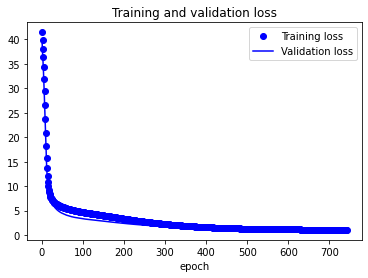

In [205]:
# training
orbit_history = orbit_model.fit(X_train_select, y_train_df[var], validation_split=0.25, epochs=1000, batch_size=128, shuffle=True, callbacks=[earlystop])

In [ ]:
# visualize results
plot_training_history(orbit_history)

In [206]:
# evaluation
orbit_pred = orbit_model.predict(X_test_select)
orbit_mse = mean_squared_error(y_test_df[var], orbit_pred, squared=False)
print(f"test mse: {orbit_mse}")

test mse: 0.7093062245398283


In [218]:
# random prediction
rand_id = np.random.randint(orbit_pred.shape[0])
print(f"Predict: {orbit_pred[rand_id]}\nTrue: \n{y_test_df[var].iloc[rand_id]}")

Predict: [ 0.13294613 29.521069    3.699114  ]
True: 
e        0.144617
a       28.347945
incl     3.165666
Name: 1647, dtype: float64


In [221]:
# save model
orbit_model.save("orbit_model")

## <a name="h">Absolute Magnitude (H) Model</a>

Next, we build our regressor model to predict H. H represents the absolute magnitude. Absolute magnitude is defined as the visual magnitude the object would have if it were 1 AU away from earth, at opposition to the sun. Obviously, as an object gets further away from the observer on Earth, it will get dimmer; likewise, if it is in it's orbit and we're only seeing partially lit portion of the asteroid due to the sun-Earth-object angle, it will also be dimmer. This standardized brightness measure becomes a proxy for the object's size. Larger objects will be brighter, with everything else constant (distance and angle). 

Using the same input data that we predict the orbital parameters with, we will predict the absolute magnitude H. This will then serve as one of the inputs to final ensemble model.

In [222]:
# y labels
var = ["H"]

In [223]:
# orbit architecture
def build_h_model():
    # inputs
    inputs = keras.Input(shape=(45))
    # dense block
    l1 = keras.layers.Dense(128, activation='relu')(inputs)
    l2 = keras.layers.Dense(64, activation='relu')(l1)
    l3 = keras.layers.Dense(64, activation='relu')(l2)
    # outputs
    outputs = keras.layers.Dense(1)(l3)
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

h_model = build_h_model()
h_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 45)]              0         
                                                                 
 dense_28 (Dense)            (None, 128)               5888      
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,369
Trainable params: 18,369
Non-trainable params: 0
_________________________________________________________________


In [224]:
# learning rate/compile
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
h_model.compile(optimizer=optimizer, 
                  loss="mse",
                  metrics=['mse'])

Epoch 1/1000
153/153 [==============================] - 2s 8ms/step - loss: 45.9578 - mse: 45.9578 - val_loss: 8.3889 - val_mse: 8.3889
Epoch 2/1000
153/153 [==============================] - 1s 6ms/step - loss: 5.2307 - mse: 5.2307 - val_loss: 3.7264 - val_mse: 3.7264
Epoch 3/1000
153/153 [==============================] - 1s 3ms/step - loss: 1.8305 - mse: 1.8305 - val_loss: 1.4691 - val_mse: 1.4691
Epoch 4/1000
153/153 [==============================] - 1s 4ms/step - loss: 0.5728 - mse: 0.5728 - val_loss: 0.7592 - val_mse: 0.7592
Epoch 5/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2311 - mse: 0.2311 - val_loss: 0.7378 - val_mse: 0.7378
Epoch 6/1000
153/153 [==============================] - 1s 4ms/step - loss: 0.1351 - mse: 0.1351 - val_loss: 0.4621 - val_mse: 0.4621
Epoch 7/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.0963 - mse: 0.0963 - val_loss: 0.3218 - val_mse: 0.3218
Epoch 8/1000
153/153 [==============================] - 0s 3

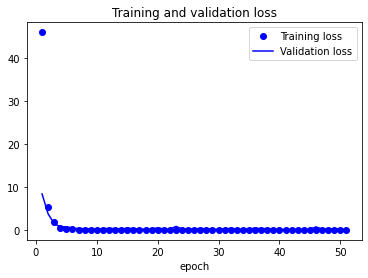

In [225]:
# training
h_history = h_model.fit(X_train_select, y_train_df[var], validation_split=0.25, epochs=1000, batch_size=128, shuffle=True, callbacks=[earlystop])

In [ ]:
# visualize results
plot_training_history(h_history)

In [226]:
# evaluation
h_pred = h_model.predict(X_test_select)
h_mse = mean_squared_error(y_test_df[var], h_pred, squared=False)
print(f"test mse: {h_mse}")

test mse: 0.16283337336657402


In [230]:
# random prediction
rand_id = np.random.randint(h_pred.shape[0])
print(f"Predict: {h_pred[rand_id]}\nTrue: \n{y_test_df[var].iloc[rand_id]}")

Predict: [13.067868]
True: 
H    13.0
Name: 1222, dtype: float64


In [231]:
# save model
h_model.save("h_model")

INFO:tensorflow:Assets written to: h_model/assets


## <a name="moid">Minimum Orbit Intersection Distance (MOID) Model</a>

MOID, or Minimum Orbit Intersection Distance, is a float constant measured in Astronomical Units (AU's). MOID represents the minimum distance of the orbit of the object to Earth's orbit. MOID values of less than 0.05 AUs are a key consideration of whether the object will be a PHA or not. Obviously, if it's orbit never comes near crossing paths with Earth, we don't need to worry about it.

In [234]:
# prep training data
X_train_moid = sbdb_df.loc[train_index, ["e", "a", "i"]]
y_train_moid = sbdb_df.loc[train_index, "moid"]

X_test_moid = sbdb_df.loc[test_index, ["e", "a", "i"]]
y_test_moid = sbdb_df.loc[test_index, "moid"]

In [239]:
# model architecture
def build_moid_model():
    # inputs
    inputs = keras.Input(shape=(3,))
    # block 1
    l1 = keras.layers.Dense(32, activation='relu')(inputs)
    l2 = keras.layers.Dense(32, activation='relu')(l1)
    # outputs
    outputs = keras.layers.Dense(1)(l2)
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [240]:
moid_model = build_moid_model()

learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
moid_model.compile(optimizer=optimizer, 
                  loss="mse",
                  metrics=['mse'])

Epoch 1/150
2899/2899 [==============================] - 9s 3ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 2/150
2899/2899 [==============================] - 6s 2ms/step - loss: 0.0864 - mse: 0.0864 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 3/150
2899/2899 [==============================] - 7s 2ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/150
2899/2899 [==============================] - 7s 2ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 5/150
2899/2899 [==============================] - 7s 2ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 6/150
2899/2899 [==============================] - 7s 2ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/150
2899/2899 [==============================] - 7s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 8/150
2899/2899 [==============================] 

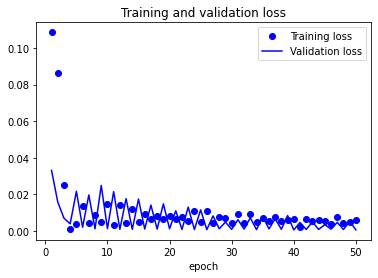

In [241]:
# training
moid_history = moid_model.fit(X_train_moid, y_train_moid, validation_split=0.25, epochs=150, batch_size=256, shuffle=True, callbacks=[earlystop])

In [ ]:
# visualize results
plot_training_history(moid_history)

In [242]:
# evaluation
moid_pred = moid_model.predict(X_test_moid)
moid_mse = mean_squared_error(y_test_moid, moid_pred, squared=False)
print(f"moid mse: {moid_mse}")

moid mse: 0.02320267451424109


In [254]:
# random predictions
rand_id = np.random.randint(moid_pred.shape[0])
print(f"Predict: {moid_pred[rand_id]}, True: {y_test_moid[rand_id]}")

Predict: [0.71930707], True: 0.717


In [255]:
# save model
moid_model.save("moid_model")

INFO:tensorflow:Assets written to: moid_model/assets


## <a name="pha">PHA Classifier Model Using Previous Models</a>

Combining the predictions of H (absolute magnitude as proxy of size) and MOID (whether it will come close to earth) will determine whether the detected object is a PHA or not.

First we train the classifier using the known H and MOIDs of the objects in the JPL Horizons catalog.

In [385]:
# prep training data
X_train_pha = sbdb_df.loc[train_index, ["H", "moid"]]
y_train_pha = sbdb_df.loc[train_index, "pha"]

X_test_pha = sbdb_df.loc[test_index, ["H", "moid"]]
y_test_pha = sbdb_df.loc[test_index, "pha"]


In [433]:
def build_pha_model():
    # inputs
    inputs = keras.Input(shape=(2,))
    # block 1
    l1 = keras.layers.Dense(4, activation='relu')(inputs)
    # l2 = keras.layers.Dense(4, activation='relu')(l1)
    # outputs
    outputs = keras.layers.Dense(1, activation='sigmoid')(l1)
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [434]:
pha_model = build_pha_model()

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
pha_model.compile(optimizer=optimizer, 
                  loss="binary_crossentropy",
                  metrics=['accuracy'])

Epoch 1/5
5797/5797 [==============================] - 12s 2ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.0056 - val_accuracy: 0.9980
Epoch 2/5
5797/5797 [==============================] - 11s 2ms/step - loss: 0.0054 - accuracy: 0.9979 - val_loss: 0.0048 - val_accuracy: 0.9980
Epoch 3/5
5797/5797 [==============================] - 16s 3ms/step - loss: 0.0046 - accuracy: 0.9980 - val_loss: 0.0040 - val_accuracy: 0.9982
Epoch 4/5
5797/5797 [==============================] - 12s 2ms/step - loss: 0.0038 - accuracy: 0.9983 - val_loss: 0.0033 - val_accuracy: 0.9985
Epoch 5/5
5797/5797 [==============================] - 12s 2ms/step - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0030 - val_accuracy: 0.9985


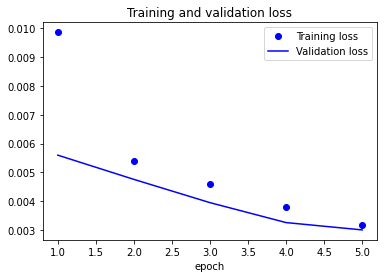

In [435]:
# training
pha_history = pha_model.fit(X_train_pha, y_train_pha, validation_split=0.25, epochs=5, batch_size=128, shuffle=True)

In [8]:
# visualize results
plot_training_history(pha_history)

NameError: name 'plot_training_history' is not defined

In [436]:
# evaluation
pha_pred = pha_model.predict(X_test_pha)
pha_score = roc_auc_score(y_test_pha, pha_pred)
print(f"AUC score: {pha_score}")

AUC score: 0.9997765259090274


In [437]:
# random prediction
rand_id = np.random.randint(pha_pred.shape[0])
print(f"Predict: {pha_pred[rand_id]}, True: {y_test_pha[rand_id]}")

Predict: [8.553975e-31], True: 0


In [438]:
# save model
pha_model.save("pha_model")

INFO:tensorflow:Assets written to: pha_model/assets


### Ensemble Classifier

Here is where we build our final model, combining the inputs from the previous models in the pipeline. The training inputs to the model are the original observational data from JPL Horizons. **Predicitons of PHA classification can be performed on newly detected objects using this ensemble of models.**

In [439]:
# Prep data
y_train_ensemb = X_train_df['targetname_0'].apply(convert2sbdb).map(sbdb_df['pha'])
X_train_ensemb = X_train_select[~y_train_ensemb.isnull()]
y_train_ensemb = y_train_ensemb[~y_train_ensemb.isnull()]
y_test_ensemb = X_test_df['targetname_0'].apply(convert2sbdb).map(sbdb_df['pha'])
X_test_ensemb = X_test_select[~y_test_ensemb.isnull()]
y_test_ensemb = y_test_ensemb[~y_test_ensemb.isnull()]


(12610, 45)
(12610,)
(970, 45)
(970,)


In [466]:
def build_pha_classifier(orbit_model, h_model, moid_model, pha_model):
    # inputs
    inputs = keras.Input(shape=(45), name='obs_4')
    # predict orbit parameters
    orbit_layer = orbit_model([inputs], training=False)
    
    # predict H
    h_layer = h_model([inputs], training=False)
    # predict moid
    moid_layer = moid_model(orbit_layer, training=False)
    # classify PHA
    pha_layer = pha_model(tf.stack([h_layer, moid_layer], axis=1), training=False)
    model = keras.models.Model(inputs=[inputs], outputs=[pha_layer])
    return model

In [467]:
# Load Models
orbit_model = keras.models.load_model('orbit_model')
h_model = keras.models.load_model('h_model')
moid_model = keras.models.load_model('moid_model')
pha_model = keras.models.load_model('pha_model')

pha_classifier = build_pha_classifier(orbit_model, h_model, moid_model, pha_model)

In [468]:
pha_classifier.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 obs_4 (InputLayer)             [(None, 45)]         0           []                               
                                                                                                  
 model_6 (Functional)           (None, 3)            18499       ['obs_4[0][0]']                  
                                                                                                  
 model_7 (Functional)           (None, 1)            18369       ['obs_4[0][0]']                  
                                                                                                  
 model_9 (Functional)           (None, 1)            1217        ['model_6[0][0]']                
                                                                                           

In [471]:
# evaluation
pha_pred = pha_classifier.predict(X_train_ensemb)
pha_score = roc_auc_score(y_train_ensemb, pha_pred)
print(f"AUC score: {pha_score}")

AUC score: 0.7614756676063168


In [482]:
# random prediction
rand_id = np.random.randint(pha_pred.shape[0])
print(f"Predict: {pha_pred[rand_id]}, True: {y_train_ensemb.iloc[rand_id]}")

Predict: [2.4765519e-24], True: 0.0


## <a name="results">Results and Conclusions</a>

General data coming from any telescopic sky survey can be used as an input to this model. The telescope need only provide the computations of the input parameters based on the series of observations taken in 3+ image sequence. The overall goal of this model, to classify likely PHAs, can then be used to flag a particular object as critical for follow up observations on a larger, more sensitive instrument. Given that telescope time is often at a premium, it is important to focus these follow up observations with the best accuracy possible. There is a tradeoff of false positives (wasted telescope time observing a non-NEO) and false negatives (missing a true NEO because we thought it wasn't a PHA) that we wish to minimize, in our efforts to catalog NEOs as early as possible. 

The AUC of 76% represents a very useful model to automate the priortization of dozens of daily discoveries from any general sky survey, and allow astronomers to spend less time doing rote tasks related to the discovery of NEOs.

## <a name="references">References</a>

- "A Method for Detection of Small Moving Objects in UAV Videos," Stojnic et al. 2021. Remote Sensing. https://www.mdpi.com/2072-4292/13/4/653/pdf
- https://ssd.jpl.nasa.gov/horizons/
- https://ssd.jpl.nasa.gov/tools/sbdb_query.html
- https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html
- https://cneos.jpl.nasa.gov/about/neo_groups.html